In [1]:
import numpy as np
from numpy.linalg import norm
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

np.set_printoptions(precision=None, suppress=True)


In [2]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=120):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate it's vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

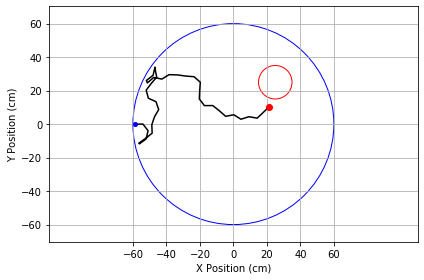

Clever rat, you found the platform in 40 seconds!


In [3]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze()

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in",maze.t,"seconds!")
else:
    print("No more time for you dumb-dumb...")

In [4]:
#helper functions to initialize the place cell center points in a circular manner 
def circle_points(r, n): #r is array of radii, n is number of points per radius
    circles = [] 
    for r, n in zip(r, n):
        t = np.linspace(0, (2*math.pi), n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def initialize_place_cells(): 
    #hard code in r and n to get the 493 place cells for this purpose
    r = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60] #radii of concentric circles
    n = [1,7, 15,20,25,35,50,60,80,90,110] # 493 place cells total; number of place cells per concentric circle
    cells = np.array(circle_points(r, n))
    stacked = np.vstack(cells)
    return np.array(stacked)

In [24]:
class actor_critic_coord(object):
    def __init__(self, place_cells=initialize_place_cells(), critic_network=np.full(493,0.5), actor_network=np.zeros((493,8)), gamma=.98, alpha_A=.1,alpha_C=.01 ,sigma=16.0,platform_radius=10, platform_location=np.array([[25,25]]), _lambda=.9): #gamma is the discount; alpha is the learning rate
       
        self.T = 120 
        
        self.place_cells = place_cells #stores the value of the center of the placefield, initialized above ^
        
        self.W = critic_network.astype(float) #493x1 array btw 1 critic and 493 place cells
        
        self.Z = actor_network.astype(float) #network of weights btw actor and place cells (493,8)
        
        self.a_coord = 0
        
        self.stored_fi = np.zeros((120,493)) #make an array to store the fi array at each time step. (store in the rows)
        
        self.XYmem = np.array([None,None])# the X', Y' memory cells
        
        self.wx = np.full(493,0.5) #weights btw the X position cell and the activity
        self.wy = np.full(493,0.5) #weights btw the Y position cell and the activity of place cells 
        
        self.maze = watermaze()
        
        
        self.gamma = gamma #discount factor
        self.alpha_A = alpha_A #learning rate for actor
        self.alpha_C = alpha_C #learning rate for critic
        self.sigma = sigma #radius of the place field
        self._lambda = _lambda #discount factor for the X and Y
    
        self.platform_location = platform_location #same platform location as the mouse maze one; in multi-platform case you input the other platform as an argument to the funtion.
       
        self.platform_radius = platform_radius 
        
    def get_position(self):
        cur_t = self.maze.t
        cur_x = self.maze.position[0][cur_t] #to convert the position to an [x,y] format that is more easily accessible
        cur_y = self.maze.position[1][cur_t]
        return (cur_x, cur_y)
    
    #Equation 1: the fi function. returns an (493,) array of the activities of all the cells
    def place_activity(self):
        cur_pos = self.get_position() #get the current position
        pos_vec = np.array([cur_pos]*493) #get a vector to get all the activities at once
        norms = np.linalg.norm(pos_vec-self.place_cells, axis=1) #take the norm along each row (each pair of points)
        norms_sqr = np.square(norms).astype(float)
        fi = np.exp(-norms_sqr/(2*self.sigma**2))
        if np.amax(abs(fi))>=100.0:
            fi = (100.0*fi)/np.amax(abs(fi)) #limit size of activity to avoid overflow
        return np.array(fi).astype(float) #returns the activities of the place cells at the current position.
    
    #the aj function. returns a 8,1 array of the activities of the actor cells at this current position.
    def actor_activity(self):
        a = ((self.Z).T).dot(self.place_activity())
        if np.amax(abs(a))>=100.0:
            a = (100.0*a)/np.amax(abs(a)) #limit size of activity to avoid overflow
        return a.astype(float) 
    
    #Equation 9. PMF of the distribution. stochastic probability of swimming in a direction
    def ProbJ(self, actor_activity):
        values = [0, 1, 2, 3, 4, 5, 6, 7]
        prob_dist = np.exp(2.0*actor_activity)/(np.sum(np.exp(2.0*actor_activity))+math.exp(self.a_coord)) #modified to include the a_coord term
        normalized_weights = prob_dist/np.sum(prob_dist) #had to normalize bc adding in a_coord made probabilites not sum to 1.
        resample_counts = np.random.multinomial(20, normalized_weights) 
        chosen = []
        resample_index = 0
        for resample_count in resample_counts: #sample from the new distribution and return the max sampled one
            for _ in range(resample_count):
                chosen.append(values[resample_index])
            resample_index += 1
        choice = np.argmax(resample_counts)
        return choice

       
    #Equation 2: C(p) function, at the current location.
    def Critic_Value(self): 
        Cp = (self.W).dot(self.place_activity()) #sum of wifi
        return Cp 
    
    #X(p) function which uses the fi(p) activity of place cells to calculate this value (it is a NUMBER just like C(p)
    def Xp(self):
        val_X = (self.wx).dot(self.place_activity()) 
        return val_X

    #Y(p) function, returns the value of Y(p) (a number, just like C(p) and X(p))
    def Yp(self):
        val_Y = (self.wy).dot(self.place_activity()) 
        
        return val_Y
    
    #calculate error (DELTA)
    def delta_calc(self, Cp_curpos, Cp_nextpos, Rt):
        delta = Rt+self.gamma*Cp_curpos-Cp_nextpos
        return delta
    
    #to see if the mouse has found the platform
    def found_platform(self):
        cur_pos = self.get_position()
        x = cur_pos[0]
        y = cur_pos[1]
  #      coords = np.array([[x], [y]])
        return np.sqrt(np.sum((cur_pos - self.platform_location)**2)) <= (self.platform_radius + 1)
    
   

    #reward for the single platform case
    def get_reward(self):
        if self.found_platform(): 
            return 1.0
        else:
            return 0.0
        
    #calculates the derivative wrt weights of the loss function, mulitplied by the initial activities
    #basically the right side of equation 8
    def E2(self, Cp_curpos, Cp_nextpos, Rt, initial_activities):
        deriv = (Rt+self.gamma*Cp_nextpos-Cp_curpos)*initial_activities #multiplies each entry in the activity matrix by this coefficient
        return deriv #a 1,144 matrix
    
    #function to update self.W (between Critic and Place cells); 144,1 array
    #updating W according to equation 8
    def update_W(self, Cp_curpos, Cp_nextpos, Rt, initial_activities):
        deriv = self.E2(Cp_curpos, Cp_nextpos, Rt, initial_activities) #calculate the gradient
        updated = self.W+self.alpha_C*deriv #multiply the current 
        self.W = updated
  
    #update Actor-place weights, according to equation 9.
    def update_Z(self,Cp_curpos, Cp_nextpos, Rt, initial_activities, move_index):        
        delta = self.E2(Cp_curpos, Cp_nextpos, Rt, initial_activities) #calculate the gradient
        delta = delta.flatten()
        col = self.Z[:,move_index] 
        col = col+self.alpha_A*delta
        self.Z[:,move_index] = col #only the column that corresponds to the index of the chosen actor cell gets updated; others stay the same
        
    #to calculate the sigma term in the X and Y updates
    def calc_sigma(self, t):
        _sum = np.zeros(493)
        for k in range(0, t+1):
            S = (self._lambda**(t-k))*self.stored_fi[k] #get the stored place cell activity at index k
            _sum = np.add(_sum, S)
        return _sum
            
        
    #delX is change in X position from t to t+1, Xp_cur is X(pt) Xp_next is X(pt+1) 
    def update_wx(self, delX, Xp_cur, Xp_next, t):
        sig = self.calc_sigma(t)
        updated = (delX-Xp_next-Xp_cur)*sig
        self.wx = updated
        
    def update_wy(self, delY, Yp_cur, Yp_next, t):
        sig = self.calc_sigma(t)
        updated = (delY-Yp_next-Yp_cur)*sig
        self.wy = updated
        
    #delta t is calculated delta_calc fn.
    def update_a_coord(self, delta_t):
        new_a_coord = self.a_coord + self.alpha_A*delta_t
        self.a_coord = new_a_coord
    
    #to reset the positions stored, set time to 0, and choose a new start location for the rat between epochs
    def reset_trial(self, start_pos):
        self.maze.position = np.zeros((2,self.maze.T))
        self.maze.t = 0
        condition = 2*start_pos
        angle = self.maze.direction[condition]
        self.maze.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.maze.radius - 1)

    #to train the model and update the weights
    #num_epochs is # of epochs, plot_all is T/F to choose if you want all the path plots to be shown (since plotting each time can clutter the screen), multi_platform is True/False to choose if you want to do RMW (false) or DMP (True; changes the platform location every 5 trials)
    def train(self, num_epochs, plot_all, multi_platform): 
        self.maze.startposition()
        epochs_arr = np.arange(1, num_epochs+1, 1)  #make arrays to store the time it took for each epoch
        trial_lengths = np.zeros(num_epochs)

        for epoch in range(num_epochs):
            print("Epoch: ", epoch)
            
            if(not multi_platform):
                print("======Single-Platform RMW=====")
                
            if(multi_platform and epoch%10==0): #switch the platform every 5 trials
                print("======Multi-Platform DMP=====")
                #generate a random point
                R= 45 #radius of the pool - a little bit so that it doesnt generate too close to the edge
                r = R * math.sqrt(np.random.rand())
                theta = np.random.rand()*2*math.pi
                x = r*np.cos(theta)
                y =  r*np.sin(theta)

                self.maze.platform_location = np.array([x,y])
                self.platform_location = np.array([x,y])
            
            start_ind=np.random.randint(0, 4) #choose a new start index for each epoch and use it for reset_trial function
            self.reset_trial(start_ind)
            
            while((not self.maze.timeup())): 

                cur_t = self.maze.t #get the initial t.
                
                cur_pos = self.get_position() #starting position
                init_pc_activities = self.place_activity() #initial place activity
                self.stored_fi[self.maze.t:]= init_pc_activities
                cp_cur = self.Critic_Value() #critic value...
                Xp_cur = self.Xp()
                Yp_cur = self.Yp()
        
                init_actor_activities = self.actor_activity()
        
                R1 = self.get_reward() #reward at time t      
                
                move_index = self.ProbJ(init_actor_activities) #best movement index according to the probability distribution fn.
                self.maze.move(move_index)
                new_pos = self.get_position() #position after move
                new_activities = self.place_activity() #activity after move
                cp_after = self.Critic_Value() #critic value after move
                Xp_next = self.Xp() #evaluation of Xp after move
                Yp_next = self.Yp() #evaluation of Yp after move
                
                delta = self. delta_calc(cp_cur, cp_after, R1) #calculate the error; used in update_a_coord
                
                delX = new_pos[0]-cur_pos[0] #calculate the change in x and y
                delY = new_pos[1]-cur_pos[1]
                
                #update all weights.
                self.update_wx(delX, Xp_cur, Xp_next, cur_t)
                self.update_wy(delY, Yp_cur, Yp_next, cur_t)
                
                self.update_W(cp_cur, cp_after, R1, new_activities)
                self.update_Z(cp_cur, cp_after, R1,new_activities, move_index)
                
                self.update_a_coord(delta)
                
                #if check if it's reached the platform and set the time accordingly
                if(self.found_platform()):
                    print("Reached goal!") 
                    self.XYmem = self.get_position() #set the memory cell
                    trial_lengths[epoch] = self.maze.t
                    if(plot_all):
                        self.maze.plotpath()
                    break

                #if it times out, print time's up and set the corresponding slot in the array to None (indicating it was unsuccessful)
                if(self.maze.timeup()):
                    print("Time's up.")   
                    trial_lengths[epoch] = None
                    if(plot_all):
                        self.maze.plotpath()

                    break
            print("===================================================")

        #plot the latency
        plt.plot(epochs_arr,trial_lengths)
        plt.xlabel('Epoch number')
        plt.ylabel('Time steps')
        if(multi_platform):
            plt.title("Multi-Platform DMP Performance (Coordinate System)")
        #    plt.savefig('coordinate_DMP.eps')
        else:
            plt.title("Single-Platform RMW Performance (Coordinate System)")
         #   plt.savefig('coordinate_RMW.eps')
        plt.show()

    
        
        
    
    

Epoch:  0
======Multi-Platform DMP=====
Time's up.
Epoch:  1
Reached goal!
Epoch:  2


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in multiply
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: overflow encountered in multiply


Reached goal!
Epoch:  3
Reached goal!
Epoch:  4
Reached goal!
Epoch:  5
Reached goal!
Epoch:  6
Reached goal!
Epoch:  7
Time's up.
Epoch:  8
Time's up.
Epoch:  9
Reached goal!
Epoch:  10
======Multi-Platform DMP=====
Reached goal!
Epoch:  11
Time's up.
Epoch:  12
Reached goal!
Epoch:  13
Reached goal!
Epoch:  14
Reached goal!
Epoch:  15
Reached goal!
Epoch:  16
Reached goal!
Epoch:  17
Reached goal!
Epoch:  18
Time's up.
Epoch:  19
Reached goal!
Epoch:  20
======Multi-Platform DMP=====
Time's up.
Epoch:  21
Time's up.
Epoch:  22
Time's up.
Epoch:  23
Time's up.
Epoch:  24
Time's up.
Epoch:  25
Time's up.
Epoch:  26
Time's up.
Epoch:  27
Time's up.
Epoch:  28
Time's up.
Epoch:  29
Time's up.
Epoch:  30
======Multi-Platform DMP=====
Time's up.
Epoch:  31
Time's up.
Epoch:  32
Time's up.
Epoch:  33
Time's up.
Epoch:  34
Time's up.
Epoch:  35
Time's up.
Epoch:  36
Time's up.
Epoch:  37
Time's up.
Epoch:  38
Time's up.
Epoch:  39
Time's up.
Epoch:  40
======Multi-Platform DMP=====
Time's up

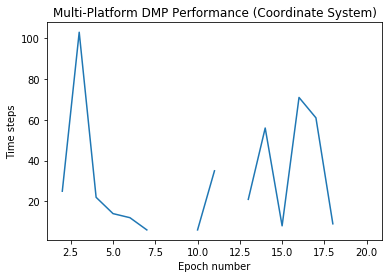

In [33]:
act = actor_critic_coord()

#act.train(30, False,False) #this one does the single-platform case


act.train(50,False,True) #multi-platform case. Note that the platform location changes every 10 epochs (hard-coded above)

